# Model building

In [1]:
# Imports 

import requests
import zipfile
import os
import pandas as pd
import ftplib
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load the merged and preprocessed data
data = pd.read_csv('data/preprocessed_data.csv')

## Simple model: linear regression

In [3]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [4]:
# target 
y = data.SOG_norm

# predictors
features = ['VHM0_norm','VMDR_norm','Temperature_norm','Salinity_norm'] 
X = data[features]

# split data to train and validation
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

In [5]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_X, train_y)

# Make predictions using the testing set
pred_y = regr.predict(val_X)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(val_y, pred_y))
# R2: 1 is perfect prediction
print('R^2: %.2f'
      % r2_score(val_y, pred_y))

Coefficients: 
 [0.14661334 0.04047778 0.13590311 0.08404383]
Mean squared error: 0.03
R^2: 0.04


## Intermediate model: Random forest

In [6]:
from joblib import dump, load
from pathlib import Path

my_file = Path("data/rf_model.joblib")
if my_file.is_file():
    forest_model = load('data/rf_model.joblib') 
else:
    forest_model = RandomForestRegressor(random_state=1)
    forest_model.fit(train_X, train_y)
    pred_y = forest_model.predict(val_X)
    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(val_y, pred_y))
    # R2: 1 is perfect prediction
    print('R^2: %.2f'
          % r2_score(val_y, pred_y))
    dump(forest_model, 'data/rf_model.joblib') 

#Add variable importance
feature_importance_values = forest_model.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

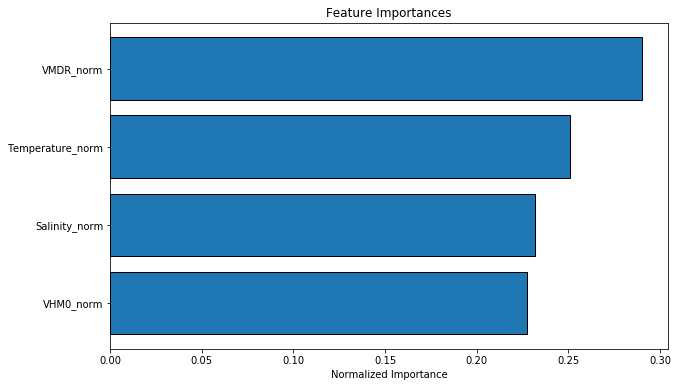

In [7]:
def plot_feature_importances(df):
    """Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called 'importance'
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

# Routing

In [8]:
# Join all wave products by using open_mfdataset, chunking data in response to memory issues
wav_all = xr.open_mfdataset('data/routing/mf*.nc')

In [9]:
phy_all = xr.open_mfdataset('data/routing/me*.nc')

### Area of interest

Calculate the optimal shipping route between Lisbon and Rio de Janeiro avoiding high waves.

Lisbon: 38.716666° N 9.1667° W

Rio de Janeiro: 22.908333° S 43.196389° W

In [10]:
# Get array index to the value that is closest to a given value
def get_closest(array, value):
    return np.abs(array - value).argmin()

In [11]:
# Set bounding box for the allowed routing corridor
bbox = ((-45, -25),(-7, 41))
# Select time
time_slice_wav = 3
time_slice_phy = 0

In [12]:
# Get indices of the bbox
lon_min = get_closest(wav_all.longitude.data, bbox[0][0])
lat_min = get_closest(wav_all.latitude.data, bbox[0][1])
lon_max = get_closest(wav_all.longitude.data, bbox[1][0])
lat_max = get_closest(wav_all.latitude.data, bbox[1][1])

## Define the weights

## Very simple solution: Calculate optimal route (minimum cost path) based on one variable _wave height_ for _one_ day

In [13]:
# Extract array from dataset to define the cost in the routing algorithm 
# Wave height
wave_height = wav_all.VHM0.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Wave direction
wave_dir = wav_all.VMDR.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Temperature
temp = phy_all.thetao.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

# Salinity
sal = phy_all.so.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

### Start and end point of the route

In [14]:
lat_Lis = 38.716666
lon_Lis = -9.1667
lat_Rio = -22.908333
lon_Rio = -43.196389

In [15]:
start_lon = get_closest(wave_height.longitude.data, lon_Lis)
start_lat = get_closest(wave_height.latitude.data, lat_Lis)
end_lon = get_closest(wave_height.longitude.data,lon_Rio)
end_lat = get_closest(wave_height.latitude.data,lat_Rio)

In [16]:
start = (start_lat, start_lon)
end = (end_lat, end_lon)

In [17]:
land_mask = wave_height.data

In [18]:
# mask for land areas
land_mask[np.isnan(land_mask)] = 1

In [19]:
start[1]

430

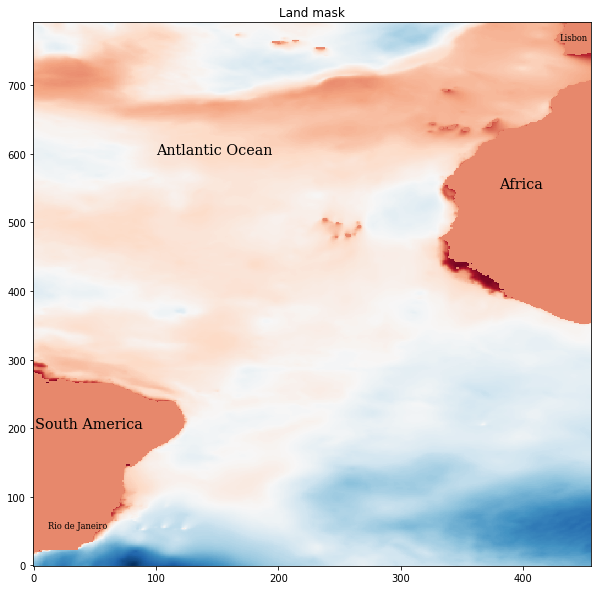

In [20]:
# Plot optimal route
plt.figure(figsize=(10,10))

# Costs
plt.imshow(land_mask, aspect='auto', cmap = "RdBu")
plt.text(start[1],start[0], "Lisbon", color = "black", fontfamily="serif", fontsize = "small")
plt.text(end[1]-10,end[0]+30, "Rio de Janeiro", color = "black", fontfamily="serif", fontsize = "small")
plt.text(100, 600, "Antlantic Ocean", color = "black", fontfamily="serif", fontsize = "x-large")
plt.text(1, 200, "South America", color = "black", fontfamily="serif", fontsize = "x-large")
plt.text(380, 550, "Africa", color = "black", fontfamily="serif", fontsize = "x-large")
plt.title("Land mask")
plt.gca().invert_yaxis()

In [21]:
wh_costs = wave_height.data
wd_costs = wave_dir.data
temp_costs = temp.data
sal_costs = sal.data


# Set NaN values to large wh_costs as the algorithm cannot handle NaNs
wh_costs[np.isnan(wh_costs)] = np.nanmean(wh_costs) 
wd_costs[np.isnan(wd_costs)] = np.nanmean(wd_costs) 
temp_costs[np.isnan(temp_costs)] = np.nanmean(temp_costs) 
sal_costs[np.isnan(sal_costs)] = np.nanmean(sal_costs) 

In [22]:
# Standardization and normalization of weights
def stand_and_norm (x):
    # Standardization
    x_stand = (x - np.mean(x)) / np.std(x)
    # Normalization
    x_norm = (x_stand - np.min(x_stand)) / (np.max(x_stand) - np.min(x_stand))
    return x_norm

wh_costs = stand_and_norm(wh_costs)
wd_costs = stand_and_norm(wd_costs)
temp_costs = stand_and_norm(temp_costs)
sal_costs = stand_and_norm(sal_costs)

### Calulate costs based on linear regression model

In [23]:
# Weight are taken from linear regression model
speed = 0.14661334*wh_costs + 0.04047778*wd_costs + 0.13590311*temp_costs + 0.08404383*sal_costs

# invert costs, because costs imitate speed 
inverted_speed = -1 * speed + np.abs(np.max(speed))

# inverted_speed[inverted_speed == 0] = 2*np.max(inverted_speed)

In [24]:
# assign non-water areas high values
inverted_speed = inverted_speed.compute()
inverted_speed[land_mask ==1] = inverted_speed.max()

wh_costs[land_mask ==1] = wh_costs.max()
wd_costs[land_mask ==1] = wd_costs.max()
temp_costs[land_mask ==1] = temp_costs.max()
sal_costs[land_mask ==1] = sal_costs.max()

In [25]:
from skimage.graph import route_through_array

# Calculate optimal route based on the minimum cost path

# Optional parameters:
# - fully_connected 
#     - False -> only axial moves are allowed
#     - True  -> diagonal moves are allowed
# - geometric 
#     - False -> minimum cost path
#     - True  -> distance-weighted minimum cost path

wh_indices, weight = route_through_array(wh_costs, start, end, fully_connected=True, geometric=True)
wh_indices = np.stack(wh_indices, axis=-1)

wd_indices, weight = route_through_array(wd_costs, start, end, fully_connected=True, geometric=True)
wd_indices = np.stack(wd_indices, axis=-1)

temp_indices, weight = route_through_array(temp_costs, start, end, fully_connected=True, geometric=True)
temp_indices = np.stack(temp_indices, axis=-1)

sal_indices, weight = route_through_array(sal_costs, start, end, fully_connected=True, geometric=True)
sal_indices = np.stack(sal_indices, axis=-1)

merged_indices, weight = route_through_array(inverted_speed, start, end, fully_connected=True, geometric=True)
merged_indices = np.stack(merged_indices, axis=-1)

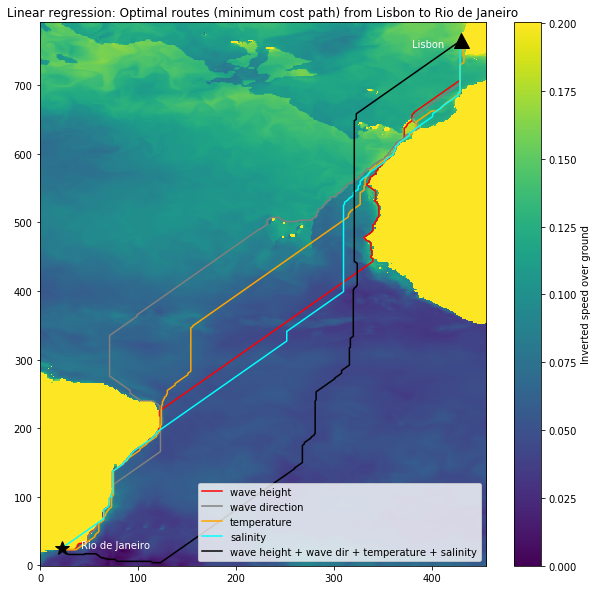

In [26]:
# Plot optimal route
plt.figure(figsize=(10,10))

# Costs
plt.imshow(inverted_speed, aspect='auto', vmin=np.min(inverted_speed), vmax=np.max(inverted_speed))

# Routes
plt.plot(wh_indices[1],wh_indices[0], 'red', label = "wave height")
plt.plot(wd_indices[1],wd_indices[0], 'grey', label = "wave direction")
plt.plot(temp_indices[1],temp_indices[0], 'orange', label = "temperature")
plt.plot(sal_indices[1],sal_indices[0], 'cyan', label = "salinity")
plt.plot(merged_indices[1],merged_indices[0], 'black', label = "wave height + wave dir + temperature + salinity")

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15)
plt.text(start_lon - 50, start_lat - 10, "Lisbon", color = "white")
plt.plot(end_lon, end_lat, 'k*', markersize=15)
plt.text(end_lon + 20, end_lat, "Rio de Janeiro", color = "white")
plt.title("Linear regression: Optimal routes (minimum cost path) from Lisbon to Rio de Janeiro")
plt.colorbar(label='Inverted speed over ground')
plt.legend(loc = "lower right")
plt.gca().invert_yaxis()

### Calulate costs based on random forest model

In [27]:
# retrieve the numpy arrays
wave_height_np = wh_costs.compute()
wave_dir_np = wd_costs.compute()
wave_height_np = temp_costs.compute()
wave_height_np = sal_costs.compute()

In [28]:
# reshape 2d array to dataframes to apply the random forest
wave_height_1d = pd.DataFrame(data = wh_costs.compute().ravel())
wave_dir_1d = pd.DataFrame(data = wd_costs.compute().ravel())
temp_1d = pd.DataFrame(data = temp_costs.compute().ravel())
sal_1d = pd.DataFrame(data = sal_costs.compute().ravel())

concat_costs = pd.concat([wave_height_1d,wave_dir_1d,temp_1d,sal_1d], axis = 1)
concat_costs.columns = ["Wave height","Wave direction","temperature","salinity"]

for_pred = forest_model.predict(concat_costs)

In [29]:
# invert costs, because costs imitate speed 
inverted_speed_forest = -1 * for_pred + np.abs(np.max(for_pred))

In [30]:
# reshape speed costs to get back the map
rf_speed = np.reshape(inverted_speed_forest,wave_height_np.shape)

In [31]:
# assign non-water areas high values
rf_speed[land_mask ==1] = np.max(rf_speed)

In [32]:
# compute route
rf_indices, weight = route_through_array(rf_speed, start, end, fully_connected=True, geometric=True)
rf_indices = np.stack(rf_indices, axis=-1)

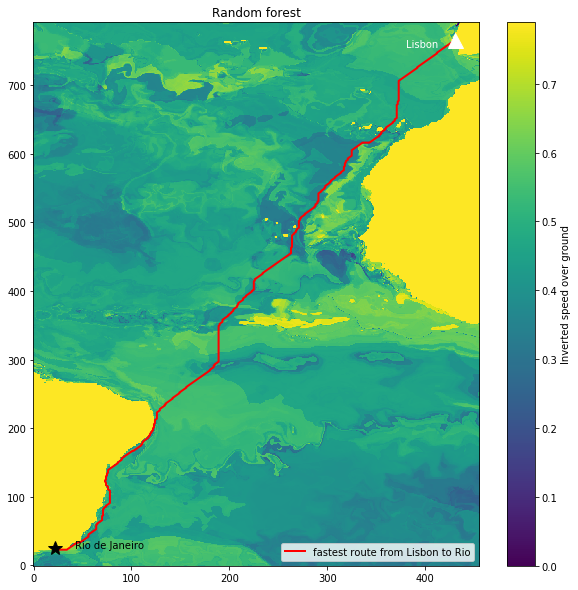

In [33]:
# Plot optimal route
plt.figure(figsize=(10,10))

# Costs
plt.imshow(rf_speed, aspect='auto')

plt.plot(rf_indices[1],rf_indices[0], 'red', label = "fastest route from Lisbon to Rio", lw = 2)

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15, color = "white")
plt.text(start_lon - 50, start_lat - 10, "Lisbon", color = "white")
plt.plot(end_lon, end_lat, 'k*', markersize=15)
plt.text(end_lon + 20, end_lat, "Rio de Janeiro")
plt.title("Random forest")
plt.legend(loc = "lower right")
plt.colorbar(label='Inverted speed over ground')
plt.gca().invert_yaxis()

## Advanced solution: Calculate optimal route (minimum cost path) based on *multiple* variables and *multiple* days

In [34]:
# Show times for WAV
time = phy_all.sel(time=~phy_all.get_index("time").duplicated()).time

rows = []

for step in range(time.size):
    
    time_df_phy = str(time.values[step])
    rows.append([step, time_df_phy])

time_df_phy = pd.DataFrame(rows, columns = ['Step', 'Time'])

In [35]:
# Show times for PHY
time = wav_all.sel(time=~wav_all.get_index("time").duplicated()).time

rows = []

for step in range(time.size):
    
    time_df_wav = str(time.values[step])
    rows.append([step, time_df_wav])

time_df_wav = pd.DataFrame(rows, columns = ['Step', 'Time'])

In [36]:
# Get the times that exist in both datasets (12:00:00 for the three days)
common_time = np.intersect1d(time_df_wav['Time'], time_df_phy['Time'])

# Create arrays with the corresponding steps
# For waves forecast, this is: [3, 11, 19, 27]
# For physics forecast, this is: [0, 1, 2, 3]
time_wav = []
time_phy = []

for t in range(common_time.size):
    time_wav.append(int(time_df_wav['Step'].loc[time_df_wav['Time'] == common_time[t]]))
    time_phy.append(int(time_df_phy['Step'].loc[time_df_phy['Time'] == common_time[t]]))

# Create time slices (start, end, step)
step_wav = time_wav[1] - time_wav[0]
time_slice_wav = slice(min(time_wav), max(time_wav) + 1, step_wav)
step_phy = time_phy[1] - time_phy[0]
time_slice_phy = slice(min(time_phy), max(time_phy) + 1, step_phy)

In [37]:
# Extract array from dataset to define the cost in the routing algorithm with a new time_slice
# Wave height
wave_height = wav_all.VHM0.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Wave direction
wave_dir = wav_all.VMDR.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Temperature
temp = phy_all.thetao.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

# Salinity
sal = phy_all.so.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

In [38]:
# Calculate multidimensional costs
wh_costs = wave_height
wh_costs = wh_costs.fillna(np.nanmean(wh_costs))
wh_costs = stand_and_norm(wh_costs)

wd_costs = wave_dir
wd_costs = wd_costs.fillna(np.nanmean(wd_costs))
wd_costs = stand_and_norm(wd_costs)

temp_costs = temp
temp_costs = temp_costs.fillna(np.nanmean(temp_costs))
temp_costs = temp_costs.reindex(latitude = wh_costs.latitude, method='nearest', tolerance=123).reindex(longitude = wh_costs.longitude, method='nearest', tolerance=123)
temp_costs = stand_and_norm(temp_costs)

sal_costs = sal
sal_costs = sal_costs.fillna(np.nanmean(sal_costs))
sal_costs = sal_costs.reindex(latitude = wh_costs.latitude, method='nearest', tolerance=123).reindex(longitude = wh_costs.longitude, method='nearest', tolerance=123)
sal_costs = stand_and_norm(sal_costs)
# Cost calulation using linear regression
# costs = 0.14661334 * wh_costs + 0.04047778 * wd_costs + 0.13590311 * temp_costs + 0.08404383 * sal_costs
# costs

In [39]:
# reshape 2d array to dataframes to apply the random forest
wave_height_1d = pd.DataFrame(data = wh_costs.values.flatten())
wave_dir_1d = pd.DataFrame(data = wd_costs.values.flatten())
temp_1d = pd.DataFrame(data = temp_costs.values.flatten())
sal_1d = pd.DataFrame(data = sal_costs.values.flatten())

concat_costs = pd.concat([wave_height_1d,wave_dir_1d,temp_1d,sal_1d], axis = 1)
concat_costs.columns = ["Wave height","Wave direction","temperature","salinity"]

# predict speed using random forest model
costs = forest_model.predict(concat_costs)

In [40]:
# reshape speed costs to get back the map
costs = np.reshape(costs,wh_costs.shape)

In [41]:
# Sum costs for all timesteps
costs_all_times = (costs[0]+costs[1]+costs[2])/3
#costs_all_times = costs.sum(dim = 'time')

In [42]:
# Get data for specific timestep
costs_day_1 = costs[0]
costs_day_2 = costs[1]
costs_day_3 = costs[2]

In [43]:
# assign max values for land areas
costs_day_1[land_mask == 1] = costs_day_1.max()
costs_day_2[land_mask == 1] = costs_day_2.max()
costs_day_3[land_mask == 1] = costs_day_3.max()

In [44]:
# assign non-water areas high values
costs_all_times[land_mask ==1] = costs_all_times.max()

In [45]:
# Calculate optimal route for all days
merged_indices_all_times, weight = route_through_array(costs_all_times, start, end, fully_connected=True, geometric=False)
merged_indices_all_times = np.stack(merged_indices_all_times, axis=-1)

# Calculate optimal route for day one
merged_indices_day_one, weight = route_through_array(costs_day_1, start, end, fully_connected=True, geometric=False)
merged_indices_day_one = np.stack(merged_indices_day_one, axis=-1)

# Calculate optimal route for day two
merged_indices_day_two, weight = route_through_array(costs_day_2, start, end, fully_connected=True, geometric=False)
merged_indices_day_two = np.stack(merged_indices_day_two, axis=-1)

# Calculate optimal route for day three
merged_indices_day_three, weight = route_through_array(costs_day_3, start, end, fully_connected=True, geometric=False)
merged_indices_day_three = np.stack(merged_indices_day_three, axis=-1)

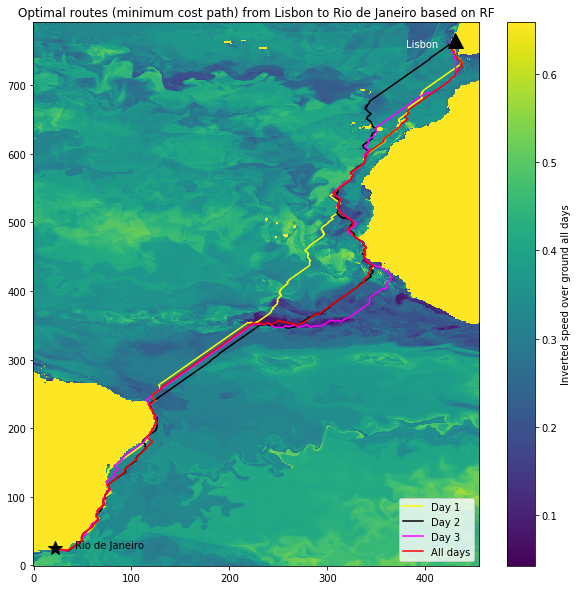

In [46]:
# Plot optimal route
plt.figure(figsize=(10,10))

# Costs
plt.imshow(costs_all_times, aspect='auto')

# Routes
plt.plot(merged_indices_day_one[1], merged_indices_day_one[0], 'yellow', label = "Day 1")
plt.plot(merged_indices_day_two[1], merged_indices_day_two[0], 'black', label = "Day 2")
plt.plot(merged_indices_day_three[1], merged_indices_day_three[0], 'magenta', label = "Day 3")
plt.plot(merged_indices_all_times[1], merged_indices_all_times[0], 'red', label = "All days")

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15)
plt.text(start_lon - 50, start_lat - 10, "Lisbon", color = "white")
plt.plot(end_lon, end_lat, 'k*', markersize = 15)
plt.text(end_lon + 20, end_lat, "Rio de Janeiro")
plt.title("Optimal routes (minimum cost path) from Lisbon to Rio de Janeiro based on RF")
plt.colorbar(label='Inverted speed over ground all days')
plt.legend(loc = "lower right")
plt.gca().invert_yaxis()

## Costs get updated per day according to euclidean distance to start point

In [47]:
# Find indices that can be reached within one day
# @see: https://stackoverflow.com/questions/52920499/find-all-points-within-distance-1-of-specific-point-in-2d-numpy-matrix
# set up matrix
day_one_mask = np.zeros(wave_height.data[0].shape) 
day_two_mask = np.zeros(wave_height.data[0].shape)
day_three_mask = np.zeros(wave_height.data[0].shape)

# convert to python scalars
r = start[0]
c = start[1]
# get boundaries of array
m, n = day_one_mask.shape

# set this value to a distance that the ship can reach within one day
dist_per_day = 300
# loop over possible locations
for i in range(0-r,m): 
    for j in range(0-c,n): 
        # check if location is within boundary
        if (0 <= r + i < m and 0 <= c + j < n):
            if np.linalg.norm([r+i,c+j] - np.array(start))<dist_per_day:
                day_one_mask[r+i,c+j] = 1
            elif np.linalg.norm([r+i,c+j] - np.array(start))>=dist_per_day and np.linalg.norm([r+i,c+j] - np.array(start))<2*dist_per_day:
                day_two_mask[r+i,c+j] = 1
            else:
                day_three_mask[r+i,c+j] = 1

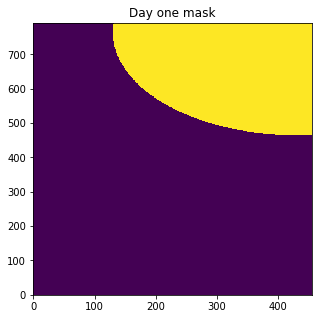

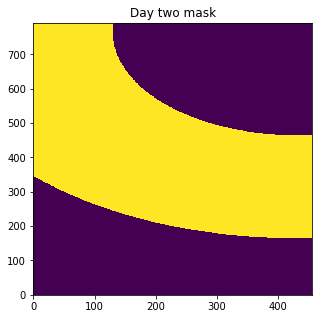

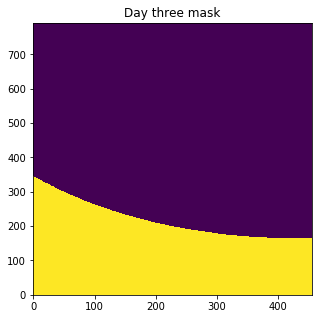

In [48]:
# Plot optimal route
plt.figure(figsize=(5,5))

# Costs
plt.imshow(day_one_mask, aspect='auto')
plt.title("Day one mask")
plt.gca().invert_yaxis()

# Plot optimal route
plt.figure(figsize=(5,5))

# Costs
plt.imshow(day_two_mask, aspect='auto')
plt.title("Day two mask")
plt.gca().invert_yaxis()

# Plot optimal route
plt.figure(figsize=(5,5))

# Costs
plt.imshow(day_three_mask, aspect='auto')
plt.title("Day three mask")
plt.gca().invert_yaxis()

In [49]:
costs_ecd = np.zeros(costs[1].shape)

In [50]:
costs_ecd[day_one_mask == 1] = costs[0][day_one_mask == 1]
costs_ecd[day_two_mask == 1] = costs[1][day_two_mask == 1]
costs_ecd[day_three_mask == 1] = costs[2][day_three_mask == 1]

In [51]:
# Calculate optimal route for all days
indices_ecd_costs, weight = route_through_array(costs_ecd, start, end, fully_connected=True, geometric=False)
indices_ecd_costs = np.stack(indices_ecd_costs, axis=-1)

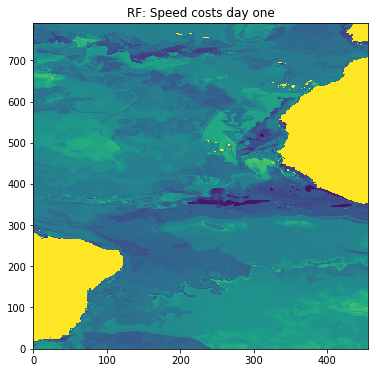

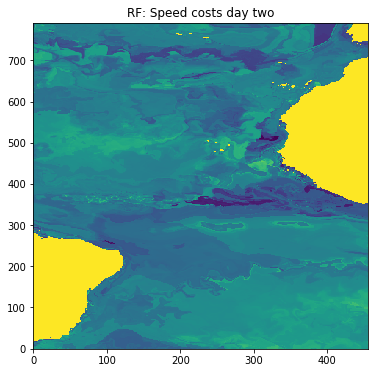

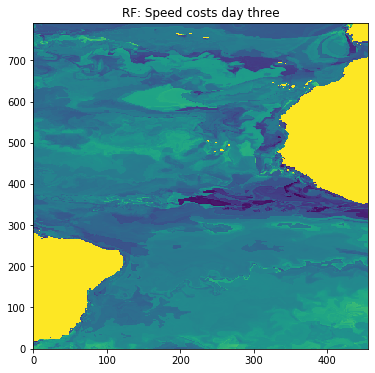

In [52]:
# Plot optimal route
plt.figure(figsize=(6,6))
# Costs
plt.imshow(costs[0], aspect='auto')
plt.title("RF: Speed costs day one")
plt.gca().invert_yaxis()

plt.figure(figsize=(6,6))
plt.imshow(costs[1], aspect='auto')
plt.title("RF: Speed costs day two")
plt.gca().invert_yaxis()

plt.figure(figsize=(6,6))
plt.imshow(costs[2], aspect='auto')
plt.title("RF: Speed costs day three")
plt.gca().invert_yaxis()

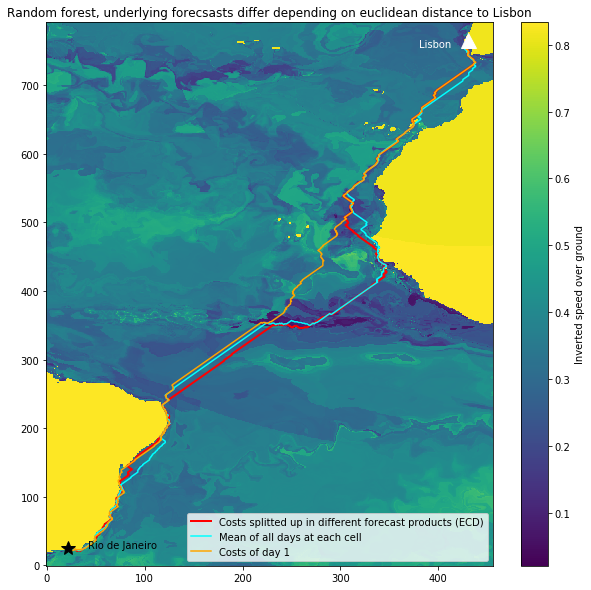

In [53]:

# Plot optimal route
plt.figure(figsize=(10,10))

# Costs
plt.imshow(costs_ecd, aspect='auto')

plt.plot(indices_ecd_costs[1],indices_ecd_costs[0], 'red', label = "Costs splitted up in different forecast products (ECD)", lw = 2)
plt.plot(merged_indices_all_times[1], merged_indices_all_times[0], 'cyan', label = "Mean of all days at each cell")
plt.plot(merged_indices_day_one[1], merged_indices_day_one[0], 'orange', label = "Costs of day 1")

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15, color = "white")
plt.text(start_lon - 50, start_lat - 10, "Lisbon", color = "white")
plt.plot(end_lon, end_lat, 'k*', markersize=15)
plt.text(end_lon + 20, end_lat, "Rio de Janeiro")
plt.title("Random forest, underlying forecsasts differ depending on euclidean distance to Lisbon")
plt.legend(loc = "lower right")
plt.colorbar(label='Inverted speed over ground')
plt.gca().invert_yaxis()

### References
* https://levelup.gitconnected.com/dijkstras-shortest-path-algorithm-in-a-grid-eb505eb3a290
* https://gist.github.com/mdsrosa/c71339cb23b <-- (Page not found..)